In [2]:
import os
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
NUM_FRAMES = 30
IMG_SIZE = 100
PATCH_SIZE = 16
EPOCHS = 20
BATCH_SIZE = 2
LR = 0.00001
FEEDFORWARD_DIM = 512
N_HEADS = 4
NUM_LAYERS = 4
DROPOUT = 0.4

video_train_data = "/kaggle/input/ptsd-new-multimodel-dataset/sorted_multimodal_data/video/training"
video_val_data   = "/kaggle/input/ptsd-new-multimodel-dataset/sorted_multimodal_data/video/validation"


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [5]:
class PTSDVideoDataset(Dataset):
    def __init__(self, data_path, transform=None, num_frames=NUM_FRAMES):
        self.data_path = data_path
        self.transform = transform
        self.num_frames = num_frames
        self.samples = []

        for label_folder in ["NO PTSD", "PTSD"]:
            folder_path = os.path.join(data_path, label_folder)
            if not os.path.isdir(folder_path):
                continue
            label = 0 if label_folder == "NO PTSD" else 1
            patient_groups = defaultdict(list)
            files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]
            for file in files:
                parts = file.split('_')
                if len(parts) < 3:
                    continue
                patient = parts[1]
                try:
                    frame_num = int(os.path.splitext(parts[2])[0])
                except:
                    continue
                full_path = os.path.join(folder_path, file)
                patient_groups[patient].append((frame_num, full_path))
            for patient, frames in patient_groups.items():
                sorted_frames = sorted(frames, key=lambda x: x[0])
                all_paths = [fp for (_, fp) in sorted_frames]
                if len(all_paths) > 0:
                    selected = [all_paths[i % len(all_paths)] for i in range(self.num_frames)]
                else:
                    selected = ["/nonexistent.jpg"] * self.num_frames
                self.samples.append((selected, label))
        print(f"Total video samples in {self.data_path}: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_files, label = self.samples[idx]
        frames = []
        for fp in frame_files:
            try:
                img = Image.open(fp).convert("RGB")
            except:
                img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (0,0,0))
            if self.transform:
                img = self.transform(img)
            frames.append(img.unsqueeze(0))
        while len(frames) < self.num_frames:
            blank = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (0,0,0))
            if self.transform:
                blank = self.transform(blank)
            frames.append(blank.unsqueeze(0))
        video_tensor = torch.cat(frames, dim=0).permute(1, 0, 2, 3)
        return video_tensor.to(device), torch.tensor(label, dtype=torch.float32).to(device)


In [6]:
dataset_train = PTSDVideoDataset(video_train_data, transform=train_transform)
dataset_val = PTSDVideoDataset(video_val_data, transform=val_transform)
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)


Total video samples in /kaggle/input/ptsd-new-multimodel-dataset/sorted_multimodal_data/video/training: 228
Total video samples in /kaggle/input/ptsd-new-multimodel-dataset/sorted_multimodal_data/video/validation: 28


In [ ]:
class StochasticLWTA(nn.Module):
    def __init__(self, embed_dim, group_size=2):
        super(StochasticLWTA, self).__init__()
        self.group_size = group_size
        self.embed_dim = embed_dim

    def forward(self, x):
        B, N, D = x.shape
        if D % self.group_size != 0:
            return x
        x = x.view(B, N, D // self.group_size, self.group_size)
        max_vals, _ = x.max(dim=-1, keepdim=True)
        mask = (x == max_vals)
        out = x * mask
        out = out.view(B, N, D)
        return out

class PaperTransformerLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=1024, dropout=0.1):
        super(PaperTransformerLayer, self).__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(d_model)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.ln3 = nn.LayerNorm(d_model)
        self.lwta = StochasticLWTA(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x_ln = self.ln1(x)
        attn_out, _ = self.self_attn(x_ln, x_ln, x_ln)
        x = x + self.dropout(attn_out)
        x_ln = self.ln2(x)
        ff_out = self.feedforward(x_ln)
        x = x + self.dropout(ff_out)
        x_ln = self.ln3(x)
        lwta_out = self.lwta(x_ln)
        x = x + self.dropout(lwta_out)
        return x


In [8]:
class PTSDTransformer(nn.Module):
    def __init__(self, img_size=IMG_SIZE, num_frames=NUM_FRAMES, patch_size=PATCH_SIZE,
                 num_classes=1, embed_dim=256, n_heads=N_HEADS, num_layers=NUM_LAYERS,
                 dim_feedforward=FEEDFORWARD_DIM, dropout=DROPOUT):
        super(PTSDTransformer, self).__init__()
        self.embedding = nn.Conv3d(3, embed_dim, kernel_size=(1, patch_size, patch_size), stride=(1, patch_size, patch_size))
        patches_per_frame = (img_size // patch_size) ** 2
        self.num_tokens = num_frames * patches_per_frame
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, embed_dim))
        self.layers = nn.ModuleList([PaperTransformerLayer(embed_dim, n_heads, dim_feedforward, dropout) for _ in range(num_layers)])
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        B, ED, T, Hf, Wf = x.shape
        x = x.reshape(B, ED, -1).transpose(1, 2)
        x = x + self.pos_embedding
        for layer in self.layers:
            x = layer(x)
        x = x.transpose(1, 2)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return self.sigmoid(x)

model = PTSDTransformer().to(device)


In [9]:
def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    best_val_acc, best_epoch = 0.0, 0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    train_r2_scores, val_r2_scores = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_preds, train_targets = [], []

        with tqdm(total=len(train_loader), desc=f"Train Epoch {epoch+1}/{epochs}") as pbar:
            for videos, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(videos).squeeze(-1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                preds = (outputs > 0.5).float()
                train_correct += (preds == labels).sum().item()
                train_total += labels.size(0)

                train_preds.extend(outputs.detach().cpu().numpy())
                train_targets.extend(labels.detach().cpu().numpy())
                pbar.update(1)

        train_acc = train_correct / train_total * 100
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)
        train_r2_scores.append(r2_score(train_targets, train_preds))

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train R2: {train_r2_scores[-1]:.4f}")

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_preds, val_targets = [], []

        with torch.no_grad():
            with tqdm(total=len(val_loader), desc=f"Val Epoch {epoch+1}/{epochs}") as pbar:
                for videos, labels in val_loader:
                    outputs = model(videos).squeeze(-1)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    preds = (outputs > 0.5).float()
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)

                    val_preds.extend(outputs.cpu().numpy())
                    val_targets.extend(labels.cpu().numpy())
                    pbar.update(1)

        val_acc = val_correct / val_total * 100
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        val_r2_scores.append(r2_score(val_targets, val_preds))

        print(f"[Epoch {epoch+1}] Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val R2: {val_r2_scores[-1]:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), "best_tublett_embedding_model.pth")

    print(f"\nBest Model saved at Epoch {best_epoch} with Val Accuracy: {best_val_acc:.2f}%")
    return train_losses, val_losses, train_accuracies, val_accuracies, train_r2_scores, val_r2_scores


In [10]:
train_losses, val_losses, train_accuracies, val_accuracies, train_r2, val_r2 = train_model(model, train_loader, val_loader)


Train Epoch 1/20: 100%|██████████| 114/114 [01:56<00:00,  1.02s/it]


[Epoch 1] Train Loss: 1.5184 | Train Acc: 58.33% | Train R2: -0.3449


Val Epoch 1/20: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


[Epoch 1] Val Loss: 0.5254 | Val Acc: 71.43% | Val R2: 0.2940


Train Epoch 2/20: 100%|██████████| 114/114 [01:04<00:00,  1.78it/s]


[Epoch 2] Train Loss: 0.6116 | Train Acc: 77.19% | Train R2: 0.3040


Val Epoch 2/20: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


[Epoch 2] Val Loss: 0.4824 | Val Acc: 82.14% | Val R2: 0.3770


Train Epoch 3/20: 100%|██████████| 114/114 [01:03<00:00,  1.79it/s]


[Epoch 3] Train Loss: 0.8584 | Train Acc: 71.49% | Train R2: 0.0909


Val Epoch 3/20: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


[Epoch 3] Val Loss: 0.5679 | Val Acc: 82.14% | Val R2: 0.3641


Train Epoch 4/20: 100%|██████████| 114/114 [01:03<00:00,  1.79it/s]


[Epoch 4] Train Loss: 0.6560 | Train Acc: 81.58% | Train R2: 0.4276


Val Epoch 4/20: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


[Epoch 4] Val Loss: 0.5647 | Val Acc: 75.00% | Val R2: 0.2694


Train Epoch 5/20: 100%|██████████| 114/114 [01:05<00:00,  1.74it/s]


[Epoch 5] Train Loss: 0.5840 | Train Acc: 81.14% | Train R2: 0.3621


Val Epoch 5/20: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


[Epoch 5] Val Loss: 0.5013 | Val Acc: 82.14% | Val R2: 0.3806


Train Epoch 6/20: 100%|██████████| 114/114 [01:05<00:00,  1.75it/s]


[Epoch 6] Train Loss: 0.6509 | Train Acc: 79.82% | Train R2: 0.3450


Val Epoch 6/20: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


[Epoch 6] Val Loss: 0.5081 | Val Acc: 82.14% | Val R2: 0.3620


Train Epoch 7/20: 100%|██████████| 114/114 [01:03<00:00,  1.78it/s]


[Epoch 7] Train Loss: 0.4732 | Train Acc: 81.14% | Train R2: 0.4581


Val Epoch 7/20: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


[Epoch 7] Val Loss: 0.5503 | Val Acc: 82.14% | Val R2: 0.3389


Train Epoch 8/20: 100%|██████████| 114/114 [01:03<00:00,  1.79it/s]


[Epoch 8] Train Loss: 0.7399 | Train Acc: 78.07% | Train R2: 0.2951


Val Epoch 8/20: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


[Epoch 8] Val Loss: 0.5245 | Val Acc: 78.57% | Val R2: 0.3429


Train Epoch 9/20: 100%|██████████| 114/114 [01:05<00:00,  1.74it/s]


[Epoch 9] Train Loss: 0.5775 | Train Acc: 81.58% | Train R2: 0.3987


Val Epoch 9/20: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


[Epoch 9] Val Loss: 0.5016 | Val Acc: 78.57% | Val R2: 0.3636


Train Epoch 10/20: 100%|██████████| 114/114 [01:05<00:00,  1.75it/s]


[Epoch 10] Train Loss: 0.6053 | Train Acc: 80.26% | Train R2: 0.3682


Val Epoch 10/20: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


[Epoch 10] Val Loss: 0.5144 | Val Acc: 75.00% | Val R2: 0.3382


Train Epoch 11/20: 100%|██████████| 114/114 [01:03<00:00,  1.79it/s]


[Epoch 11] Train Loss: 0.7206 | Train Acc: 78.07% | Train R2: 0.2796


Val Epoch 11/20: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


[Epoch 11] Val Loss: 0.5124 | Val Acc: 82.14% | Val R2: 0.3772


Train Epoch 12/20: 100%|██████████| 114/114 [01:03<00:00,  1.80it/s]


[Epoch 12] Train Loss: 0.5969 | Train Acc: 82.46% | Train R2: 0.4149


Val Epoch 12/20: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


[Epoch 12] Val Loss: 0.5095 | Val Acc: 78.57% | Val R2: 0.3417


Train Epoch 13/20: 100%|██████████| 114/114 [01:02<00:00,  1.81it/s]


[Epoch 13] Train Loss: 0.6799 | Train Acc: 77.63% | Train R2: 0.2935


Val Epoch 13/20: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


[Epoch 13] Val Loss: 0.5018 | Val Acc: 85.71% | Val R2: 0.3849


Train Epoch 14/20: 100%|██████████| 114/114 [01:03<00:00,  1.78it/s]


[Epoch 14] Train Loss: 0.6636 | Train Acc: 79.39% | Train R2: 0.3253


Val Epoch 14/20: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


[Epoch 14] Val Loss: 0.5175 | Val Acc: 85.71% | Val R2: 0.3733


Train Epoch 15/20: 100%|██████████| 114/114 [01:03<00:00,  1.80it/s]


[Epoch 15] Train Loss: 0.4716 | Train Acc: 82.89% | Train R2: 0.4740


Val Epoch 15/20: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


[Epoch 15] Val Loss: 0.4981 | Val Acc: 78.57% | Val R2: 0.3667


Train Epoch 16/20: 100%|██████████| 114/114 [01:03<00:00,  1.81it/s]


[Epoch 16] Train Loss: 0.6141 | Train Acc: 80.70% | Train R2: 0.3857


Val Epoch 16/20: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


[Epoch 16] Val Loss: 0.4760 | Val Acc: 85.71% | Val R2: 0.3924


Train Epoch 17/20: 100%|██████████| 114/114 [01:03<00:00,  1.80it/s]


[Epoch 17] Train Loss: 0.5484 | Train Acc: 82.46% | Train R2: 0.4191


Val Epoch 17/20: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


[Epoch 17] Val Loss: 0.4725 | Val Acc: 82.14% | Val R2: 0.3943


Train Epoch 18/20: 100%|██████████| 114/114 [01:03<00:00,  1.78it/s]


[Epoch 18] Train Loss: 0.5383 | Train Acc: 83.33% | Train R2: 0.4488


Val Epoch 18/20: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


[Epoch 18] Val Loss: 0.5135 | Val Acc: 85.71% | Val R2: 0.3785


Train Epoch 19/20: 100%|██████████| 114/114 [01:04<00:00,  1.78it/s]


[Epoch 19] Train Loss: 0.7317 | Train Acc: 78.95% | Train R2: 0.3176


Val Epoch 19/20: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


[Epoch 19] Val Loss: 0.5472 | Val Acc: 82.14% | Val R2: 0.3563


Train Epoch 20/20: 100%|██████████| 114/114 [01:02<00:00,  1.81it/s]


[Epoch 20] Train Loss: 0.4671 | Train Acc: 81.14% | Train R2: 0.4341


Val Epoch 20/20: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]

[Epoch 20] Val Loss: 0.5346 | Val Acc: 82.14% | Val R2: 0.3629

Best Model saved at Epoch 13 with Val Accuracy: 85.71%


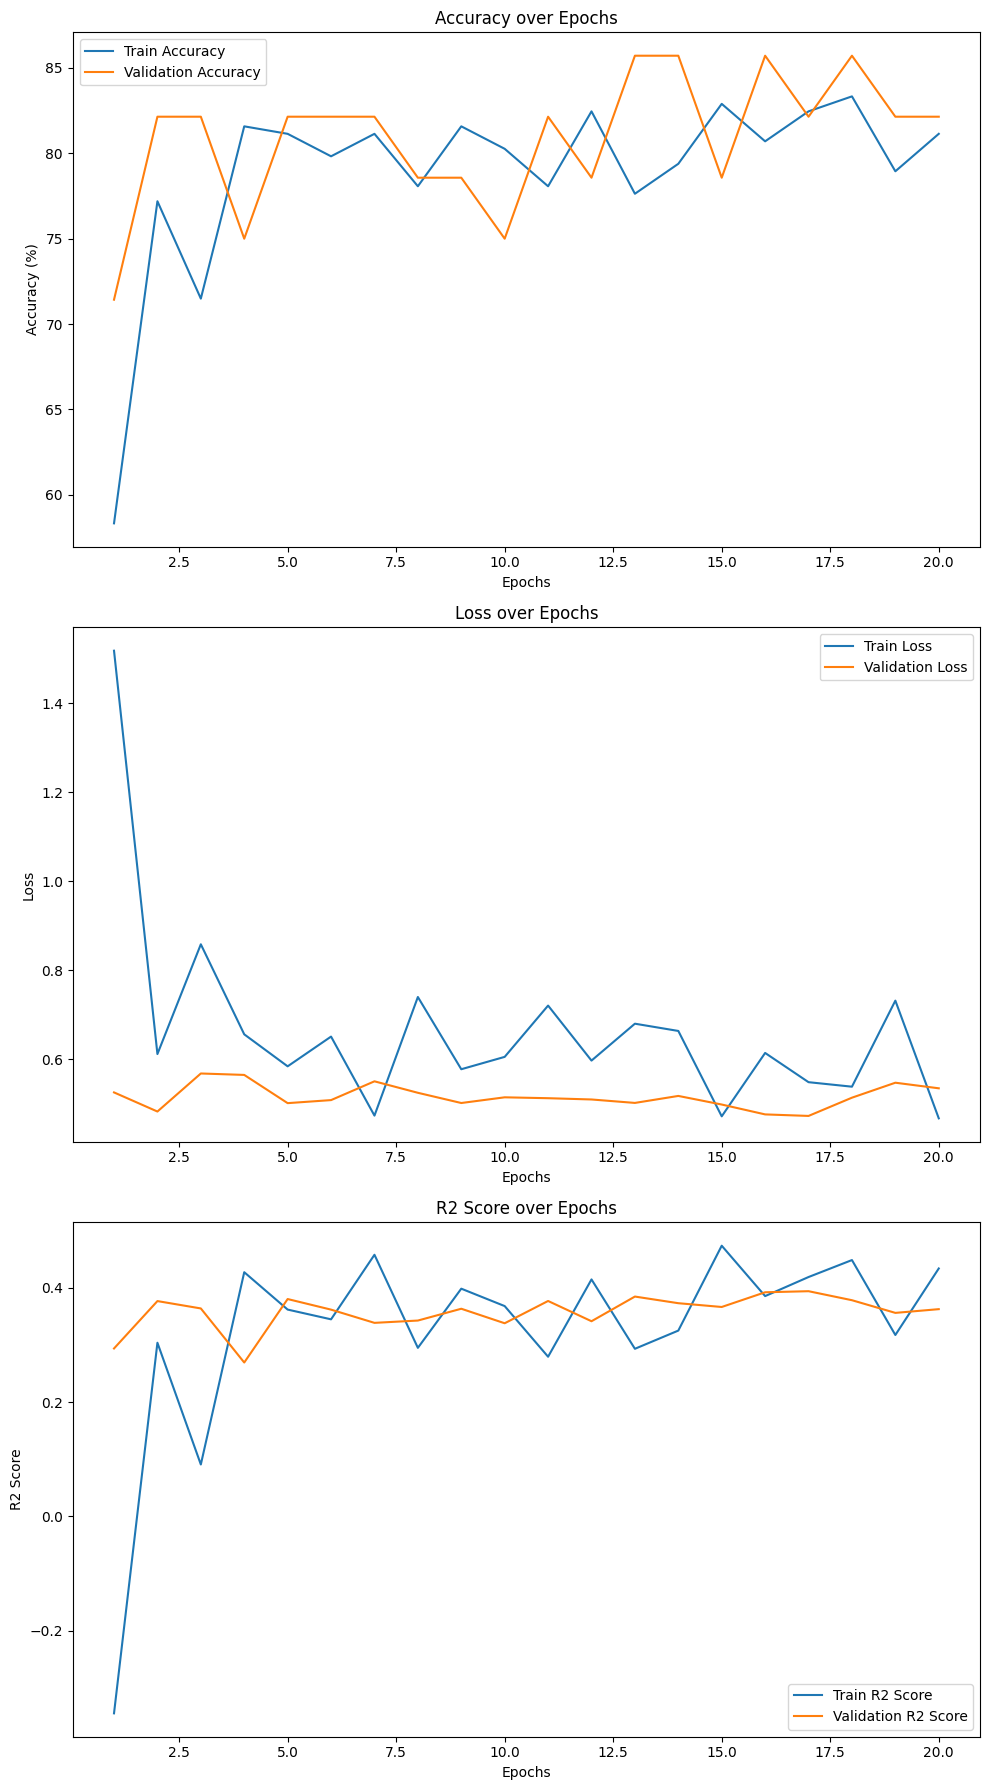

In [14]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

# 3 rows, 1 column subplot, figsize bada rakha hai height ke liye
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Accuracy graph
axs[0].plot(epochs_range, train_accuracies, label='Train Accuracy')
axs[0].plot(epochs_range, val_accuracies, label='Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_title('Accuracy over Epochs')
axs[0].legend()

# Loss graph
axs[1].plot(epochs_range, train_losses, label='Train Loss')
axs[1].plot(epochs_range, val_losses, label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss over Epochs')
axs[1].legend()

# R2 Score graph
axs[2].plot(epochs_range, train_r2, label='Train R2 Score')
axs[2].plot(epochs_range, val_r2, label='Validation R2 Score')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('R2 Score')
axs[2].set_title('R2 Score over Epochs')
axs[2].legend()

plt.tight_layout()
plt.show()
